In [8]:
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import seaborn as sns
sns.set()
sns.set_context("notebook",font_scale=0.2)
plt.close('all')

In [11]:
import numpy as np
from scipy.optimize import curve_fit

def fit_expo(x,y):
    # y = a *exp(b*x)
    
    # find linearized solution as starting point
    # log(y) = log(a) + b*x = [1 x].T @ [log(a) b]
    # the log puts emphasize on small numbers, make weighting
    logParams   = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    initParams  = (np.exp(logParams[1]), logParams[0])
    params      = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, \
                           p0=initParams)
    return params[0],params[1],initParams

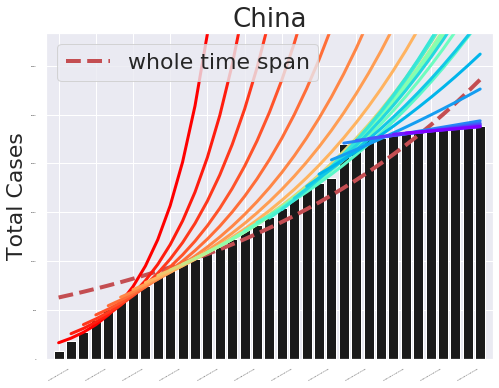

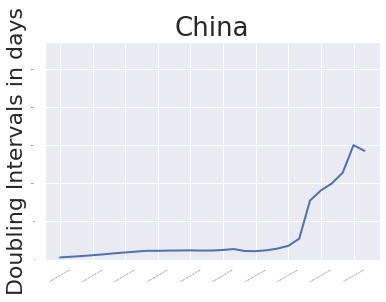

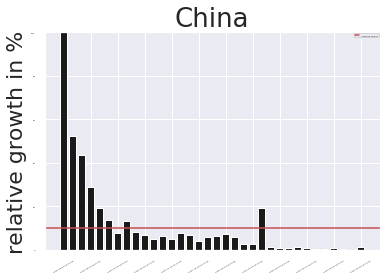

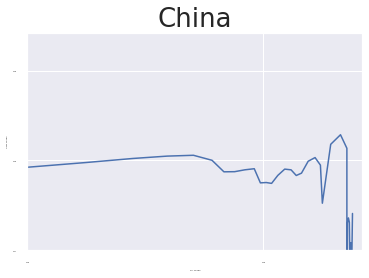

In [12]:
now         = datetime.now() 
date        = now.strftime("%d-%m-%Y") 
###comment out following line for current data (if already available)
date        = '30-03-2020'  #hard coded

url         = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"

df          = pd.read_csv(url)
country     = 'China' #e.g. South_Korea,China, United_States_of_America,United_Kingdom, Italy, Austria
df_filtered = df[df['countriesAndTerritories'] == country]  
#until 2020-03-26  'Countries and territories'

#df_filtered['Cases'].describe()  # describtive statistics

timeSpan    = 7*5  # last 5 weeks
dates = pd.DatetimeIndex(df_filtered['dateRep'][0:timeSpan])
#dates       = np.array(df_filtered['dateRep'][0:timeSpan],dtype='datetime64[D]')
#until 2020-03-26   'DateRep'

dates       = dates[::-1]
newCases    = np.array(df_filtered['cases'])[0:timeSpan] 
#unitl 2020-03-26    'Cases'                       
newCases    = newCases[::-1]  #reverse order 
allCases    = np.cumsum(newCases)+1e-10  #add small bias to avoid zeros in the data
xTicks      = np.arange(np.size(newCases))

######## fit over whole time span   ##########
plt.figure(1, figsize=(8,6))
params,_, _ = fit_expo(xTicks,allCases)
plt.plot(xTicks, params[0]*np.exp(params[1]*xTicks),'r--', linewidth = 4, label = 'whole time span')

######## sliding fit ###########
fittedDays   = 7
n            = timeSpan-fittedDays+1  #samples for sliding fit

colorMap     = cm.rainbow(np.linspace(1,0,n)) #e.g. rainbow, magma
color        = iter(colorMap)   
doublingVec  = np.zeros((n,))

for d in range(n):   
    c=next(color)
    y = allCases[d:d+fittedDays]
    x = xTicks[d:d+fittedDays]
    params,_, _ = fit_expo(x,y) 
    yFit    = params[0]*np.exp(params[1]*xTicks)
    plt.plot(xTicks[d::], yFit[d::] , c=c, linewidth = '3')    
    doublingVec[d]   = np.log(2)/params[1]      
  
plt.bar(xTicks,allCases,color = 'k', alpha=1  , align = 'center')    
plt.ylim([0,allCases[-1]*1.4])   
plt.xlim([-1, timeSpan]) 
plt.grid(True)
plt.ylabel('Total Cases', fontsize = 22)
plt.title(country.replace('_',' '), fontsize = 26)
plt.xticks(xTicks[::3], dates[::3], rotation=30)
plt.legend(loc = 2, fontsize = 22)
plt.show()


plt.figure(2)
plt.plot(xTicks[fittedDays-1::], doublingVec, linewidth = '2')
plt.xticks(xTicks[fittedDays-1::3], dates[fittedDays-1::3], rotation=30)
plt.ylabel('Doubling Intervals in days', fontsize = 22)
plt.title(country.replace('_',' '), fontsize = 26)
plt.grid(True)
plt.ylim([0, doublingVec[-1]*2])
plt.show()

plt.figure(3)
relGrowth =100*(allCases[1::]-allCases[:-1:])/allCases[:-1:]
plt.bar(xTicks[1::],relGrowth,color = 'k', alpha=1  , align = 'center')   
plt.title(country.replace('_',' '), fontsize = 26)
plt.xticks(xTicks[1::3], dates[1::3], rotation=30)
target = 10
plt.axhline(target, 0, 1,c='r', label='Austrian target')
plt.ylim([0, 100])
plt.ylabel('relative growth in %', fontsize = 22)
plt.legend(loc=1)
plt.show()

plt.figure(4)
xVal = savgol_filter(allCases, 5, 3)   #filter length, filter order
yVal = savgol_filter(newCases, 5, 3)
plt.loglog(xVal,yVal)
plt.title(country.replace('_',' '), fontsize = 26)
plt.xlim((100,max(xVal)*1.1))
plt.ylim((10,max(xVal)*1.1))
plt.xlabel('all cases')
plt.ylabel('new cases')
plt.grid(True)

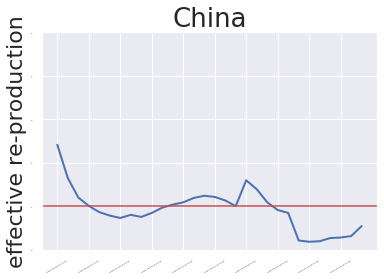

In [14]:
from scipy.stats import gamma

### effective re-production

tau     = 5#13    #tau equals number of fitted days
a       = 1
b       = 5

n       = timeSpan-tau + 1  #samples for fit
repVec  = np.zeros((n,))

for d in np.arange(1,n):   
    ii  = np.arange(d,d+tau)
    y   = newCases[ii]

    num         = a+ np.sum(y)
 
    s           = np.arange(0,d+tau)
    ws          = gamma.pdf(s,a=3,loc=0,scale=1)  # gamma parameters to play around
    ws          = ws/np.sum(ws)

    
    sum_di      = 0 
    for i in ii:
        w       = np.reshape(ws[:i:],(-1,1))
        w       = w[::-1]
        ys      = np.reshape(newCases[:i:],(1,-1))
        sum_di  += ys@w
        
        
        #unifrom dist.
        #sum_di  += np.mean(ys)
                        
    den         = 1/b +  sum_di

    repVec[d]   = num/den                
                           
plt.figure(5)
plt.plot(xTicks[tau::], repVec[1::], linewidth = '2')
plt.xticks(xTicks[tau::3], dates[fittedDays::3], rotation=30)
plt.ylabel('effective re-production', fontsize = 22)
plt.axhline(1, 0, 1,c='r', label='pandemic stop')
plt.title(country.replace('_',' '), fontsize = 26)
plt.grid(True)
plt.ylim([0, 5])
plt.show()

In [26]:
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.stats import gamma
import seaborn as sns
sns.set()
sns.set_context("notebook",font_scale=1.8)
plt.close('all')

def cost_fun():
    
def fit_expo(x,y):
    # y = a *exp(b*x)
    
    # find linearized solution as starting point
    # log(y) = log(a) + b*x = [1 x].T @ [log(a) b]
    # the log puts emphasize on small numbers, make weighting
    logParams   = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    initParams  = (np.exp(logParams[1]), logParams[0])
    params      = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, \
                           p0=initParams)
    res_1 = least_squares(lambda t,a,b: a*np.exp(b*t), x0=initParams)
    print(res_1)
    return params[0],params[1],initParams


now         = datetime.now() 
date        = now.strftime("%Y-%m-%d") 
###comment out following line for current data (if already available)
date        = '2020-04-26'  #hard coded
####################################################################
url         = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-"
url         = url +date+".xlsx"

df          = pd.read_excel(url)
country     = 'China' #e.g. South_Korea,China, United_States_of_America,United_Kingdom, Italy, Austria
df_filtered = df[df['countriesAndTerritories'] == country]  
#until 2020-03-26  'Countries and territories'

#df_filtered['Cases'].describe()  # describtive statistics

timeSpan    = 7*10#7*5  # last 5 weeks
dates       = np.array(df_filtered['dateRep'][0:timeSpan],dtype='datetime64[D]')
#until 2020-03-26   'DateRep'

dates       = dates[::-1]
newCases    = np.array(df_filtered['cases'])[0:timeSpan] 
#unitl 2020-03-26    'Cases'                       
newCases    = newCases[::-1]  #reverse order 
allCases    = np.cumsum(newCases)+1e-10  #add small bias to avoid zeros in the data
xTicks      = np.arange(np.size(newCases))

######## fit over whole time span   ##########
plt.figure(1, figsize=(8,6))
params,_, _ = fit_expo(xTicks,allCases)
plt.plot(xTicks, params[0]*np.exp(params[1]*xTicks),'r--', linewidth = 1, label = 'whole time span')

######## sliding fit ###########
fittedDays   = 5
n            = timeSpan-fittedDays+1  #samples for sliding fit

colorMap     = cm.rainbow(np.linspace(1,0,n)) #e.g. rainbow, magma
color        = iter(colorMap)   
doublingVec  = np.zeros((n,))

for d in range(n):   
    c=next(color)
    y = allCases[d:d+fittedDays]
    x = xTicks[d:d+fittedDays]
    params,_, _ = fit_expo(x,y) 
    yFit    = params[0]*np.exp(params[1]*xTicks)
    plt.plot(xTicks[d::], yFit[d::] , c=c, linewidth = '3')    
    doublingVec[d]   = np.log(2)/params[1]      
  
plt.bar(xTicks,allCases,color = 'k', alpha=1  , align = 'center')    
plt.ylim([0,allCases[-1]*1.4])   
plt.xlim([-1, timeSpan]) 
plt.grid(True)
plt.ylabel('Total Cases', fontsize = 10)
plt.title(country.replace('_',' '), fontsize = 10)
plt.xticks(xTicks[::3], dates[::3], rotation=30)
plt.legend(loc = 2, fontsize = 10)
plt.show()


plt.figure(2, figsize=(8,6))
plt.plot(xTicks[fittedDays-1::], doublingVec, linewidth = '2')
plt.xticks(xTicks[fittedDays-1::3], dates[fittedDays-1::3], rotation=30)
plt.ylabel('Doubling Intervals in days', fontsize = 10)
plt.title(country.replace('_',' '), fontsize = 10)
plt.grid(True)
plt.ylim([0, doublingVec[-1]*2])
plt.show()

plt.figure(3)
relGrowth =100*(allCases[1::]-allCases[:-1:])/allCases[:-1:]
plt.bar(xTicks[1::],relGrowth,color = 'k', alpha=1  , align = 'center')   
plt.title(country.replace('_',' '), fontsize = 26)
plt.xticks(xTicks[1::3], dates[1::3], rotation=30)
target = 10
plt.axhline(target, 0, 1,c='r', label='Austrian target')
plt.ylim([0, 100])
plt.ylabel('relative growth in %', fontsize = 22)
plt.legend(loc=1)
plt.show()

plt.figure(4)
xVal = savgol_filter(allCases, 5, 3)   #filter length, filter order
yVal = savgol_filter(newCases, 5, 3)
plt.loglog(xVal,yVal)
plt.title(country.replace('_',' '), fontsize = 26)
plt.xlim((100,max(xVal)*1.1))
plt.ylim((10,10**np.ceil(np.log10(np.max(yVal)))))
plt.xlabel('all cases')
plt.ylabel('new cases')
plt.grid(True)



### effective re-production

tau     = 5#13    #tau equals number of fitted days
a       = 1
b       = 5

n       = timeSpan-tau + 1  #samples for fit
repVec  = np.zeros((n,))

for d in np.arange(1,n):   
    ii  = np.arange(d,d+tau)
    y   = newCases[ii]

    num         = a+ np.sum(y)
 
    s           = np.arange(0,d+tau)
    ws          = gamma.pdf(s,a=3,loc=0,scale=1)  # gamma parameters to play around
    ws          = ws/np.sum(ws)

    
    sum_di      = 0 
    for i in ii:
        w       = np.reshape(ws[:i:],(-1,1))
        w       = w[::-1]
        ys      = np.reshape(newCases[:i:],(1,-1))
        sum_di  += ys@w
        
        
        #unifrom dist.
        #sum_di  += np.mean(ys)
                        
    den         = 1/b +  sum_di

    repVec[d]   = num/den                
                           
plt.figure(5)
plt.plot(xTicks[tau::], repVec[1::], linewidth = '2')
plt.xticks(xTicks[tau::3], dates[fittedDays::3], rotation=30)
plt.ylabel('effective re-production', fontsize = 22)
plt.axhline(1, 0, 1,c='r', label='pandemic stop')
plt.title(country.replace('_',' '), fontsize = 26)
plt.grid(True)
plt.ylim([0, 5])
plt.show()

TypeError: <lambda>() missing 2 required positional arguments: 'a' and 'b'

<Figure size 576x432 with 0 Axes>